In [1]:
#%%
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
import sys
from pathlib import Path
import scipy.io as sio

from spyrit.learning.model_Had_DCAN import *
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *

import os, sys
import warnings

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

#%% Functions to load the experimental Data
def read_mat_data_index(expe_data, nflip, lambda_i = 548):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    lambda_indices = np.where(np.abs(F_spectro-lambda_i)<1);
    num_channel = lambda_indices[0][0];
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_pos = F_data_pos[:,:,num_channel];
    F_neg = F_data_neg[:,:,num_channel];
    if (2**16-1 in F_pos) or (2**16-1 in F_neg):
        warnings.warn("Warning, Saturation!", UserWarning)
    F_pos = F_pos.astype("int64");
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;


def read_mat_data(expe_data, nflip, lambda_min = 460, lambda_max = 700):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F_pos = F_data_pos[:,:,F_spectro>lambda_min];
    F_neg = F_data_neg[:,:,F_spectro>lambda_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F_pos = F_pos[:,:,F_spectro<lambda_max];
    F_neg = F_neg[:,:,F_spectro<lambda_max];
    F_pos = np.sum(F_pos, axis=2);
    F_pos = F_pos.astype("int64");
    F_neg = np.sum(F_neg, axis=2);
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;

def read_mat_data_proc(expe_data, nflipi, lamda_min=460, lambda_max = 700):
    F = sio.loadmat(expe_data+"_{}_100_data.mat".format(nflip));
    F_data = F["F_WT_lambda"];
    F_spectro = F["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F = F_data[:,:,F_spectro>lamdba_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F = F[:,:,F_spectro<lambda_max];
    F = np.sum(F , axis=2);
    return F;

# warning: K not used!
def load_data_list_index(expe_data,nflip, CR, K, Perm, img_size, num_channel = 548):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        F_pos = F_pos;
        F_neg = F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list

def load_data_list(expe_data,nflip, CR, K, Perm, img_size, lambda_min = 460, lambda_max = 700):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        F_pos = 1/K*F_pos;
        F_neg = 1/K*F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list
  
def ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def raw_ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        gt_list.append(Gt);
    return gt_list


def ground_truth_list(expe_data,nflip, H, img_size, lambda_min = 460, lambda_max = 700):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, denoise, H, suffix, model_root):
    net_type = ['c0mp', 'comp','pinv', 'free']
    list_nets = [];
    for N0 in N0_list:
        recon_type = "";
        if N0==0:
            train_type = ''
        else :
            train_type = '_N0_{:g}_sig_{:g}'.format(N0,sig)
            if denoise:
                recon_type+="_Denoi";
        #- training parameters
        title = model_root + 'NET_'+net_type[net_arch]+train_type+recon_type+suffix ;
        if N0==0:
            model = compNet(img_size, CR, Mean_had, Cov_had, net_arch, H)
        else:
            if denoise:
                model = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
            else:
                model = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
        model = model.to(device);
        load_net(title,model, device);
        list_nets.append(model);
    return list_nets;

def simulated_noisy_images(gt_list, max_list, K, H):
    gt_index = max_list.index(max(max_list));
    GT = gt_list[gt_index];
    N = GT.shape[0];
    H_pos = np.zeros(H.shape);
    H_neg = np.zeros(H.shape);
    H_pos[H>0] = N*H[H>0];
    H_neg[H<0] = -N*H[H<0];
    simu_list = [];
    for i in range(len(gt_list)):
        if i!=gt_index:
            f_noi = simulated_measurement(GT, max_list[i]/K, H_pos, H_neg, N, H)
        else:
            f_noi = GT;
        simu_list.append(f_noi)
    return simu_list


def simulated_measurement(GT, N0, H_pos, H_neg, N, H):
    f = N0*np.reshape(((GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))), (N**2,1));
    m_pos = np.dot(H_pos,f);
    m_neg = np.dot(H_neg,f);
    m_pos += np.multiply(np.sqrt(m_pos),np.random.normal(0,1,size = m_pos.shape));
    m_neg += np.multiply(np.sqrt(m_neg),np.random.normal(0,1,size = m_neg.shape));
    m_noi = m_pos-m_neg;
    f_noi = np.reshape((1/N)*np.dot(H, m_pos-m_neg), (N, N));
    f_noi = 2*(f_noi-np.amin(f_noi))/(np.amax(f_noi)-np.amin(f_noi))-1;
    return f_noi;


def normalize(Img, a, b):
    return (a-b)*(Img-np.amin(Img))/(np.amax(Img)-np.amin(Img))+b;

def batch_flipud(vid):
    outs = vid;
    for i in range(vid.shape[1]):
        outs[0,i,0,:,:] = np.flipud(vid[0,i,0,:,:]);
    return outs;

#Defining functions to improve the metrics
def double_param_reg(f,g):
    N = f.shape[-2]*f.shape[-1];
    f_vec = np.reshape(f[0,0,:,:], (N,1));
    g_vec = np.reshape(g[0,0,:,:], (N,1));
    f_mean = np.mean(f_vec);
    g_mean = np.mean(g_vec);
    g_norm = np.dot(np.transpose(g_vec), g_vec);
    g_f = np.dot(np.transpose(g_vec), f_vec);
    a = (g_f - N*f_mean*g_mean)/(g_norm-g_mean**2);
    b = (f_mean*g_norm - g_mean*g_f)/(g_norm-g_mean**2);
    return a*g+b;


def single_param_reg(f,g):
    N = f.shape[-2]*f.shape[-1];
    f_vec = np.reshape(f[0,0,:,:], (N,1));
    g_vec = np.reshape(g[0,0,:,:], (N,1));
    g_norm = np.dot(np.transpose(g_vec), g_vec);
    g_f = np.dot(np.transpose(g_vec), f_vec);
    a = (g_f)/(g_norm);
    return a*g;

def diag(y):
    n = y.shape[0];
    D = np.zeros((n,n));
    D[np.diag_indices(n)] = np.reshape(y,(n,));
    return D;

def Diag(A):
    a,b = A.shape;
    n = min(a,b);
    d = np.reshape(A[np.diag_indices(n)], (n,1));
    return d;



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#%% Functions to load the experimental Data
def read_mat_data_index(expe_data, nflip, lambda_i = 548):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    lambda_indices = np.where(np.abs(F_spectro-lambda_i)<1);
    num_channel = lambda_indices[0][0];
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_pos = F_data_pos[:,:,num_channel];
    F_neg = F_data_neg[:,:,num_channel];
    if (2**16-1 in F_pos) or (2**16-1 in F_neg):
        warnings.warn("Warning, Saturation!", UserWarning)
    F_pos = F_pos.astype("int64");
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;


def read_mat_data(expe_data, nflip, lambda_min = 460, lambda_max = 700):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F_pos = F_data_pos[:,:,F_spectro>lambda_min];
    F_neg = F_data_neg[:,:,F_spectro>lambda_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F_pos = F_pos[:,:,F_spectro<lambda_max];
    F_neg = F_neg[:,:,F_spectro<lambda_max];
    F_pos = np.sum(F_pos, axis=2);
    F_pos = F_pos.astype("int64");
    F_neg = np.sum(F_neg, axis=2);
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;

def read_mat_data_proc(expe_data, nflipi, lamda_min=460, lambda_max = 700):
    F = sio.loadmat(expe_data+"_{}_100_data.mat".format(nflip));
    F_data = F["F_WT_lambda"];
    F_spectro = F["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F = F_data[:,:,F_spectro>lamdba_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F = F[:,:,F_spectro<lambda_max];
    F = np.sum(F , axis=2);
    return F;

# warning: K not used!
def load_data_list_index(expe_data,nflip, CR, K, Perm, img_size, num_channel = 548):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        F_pos = F_pos;
        F_neg = F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list

def load_data_list(expe_data,nflip, CR, K, Perm, img_size, lambda_min = 460, lambda_max = 700):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        F_pos = 1/K*F_pos;
        F_neg = 1/K*F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list
  
def ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def raw_ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        gt_list.append(Gt);
    return gt_list


def ground_truth_list(expe_data,nflip, H, img_size, lambda_min = 460, lambda_max = 700):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, denoise, H, suffix, model_root):
    net_type = ['c0mp', 'comp','pinv', 'free']
    list_nets = [];
    for N0 in N0_list:
        recon_type = "";
        if N0==0:
            train_type = ''
        else :
            train_type = '_N0_{:g}_sig_{:g}'.format(N0,sig)
            if denoise:
                recon_type+="_Denoi";
        #- training parameters
        title = model_root + 'NET_'+net_type[net_arch]+train_type+recon_type+suffix ;
        if N0==0:
            model = compNet(img_size, CR, Mean_had, Cov_had, net_arch, H)
        else:
            if denoise:
                model = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
            else:
                model = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
        model = model.to(device);
        load_net(title,model, device);
        list_nets.append(model);
    return list_nets;

def simulated_noisy_images(gt_list, max_list, K, H):
    gt_index = max_list.index(max(max_list));
    GT = gt_list[gt_index];
    N = GT.shape[0];
    H_pos = np.zeros(H.shape);
    H_neg = np.zeros(H.shape);
    H_pos[H>0] = N*H[H>0];
    H_neg[H<0] = -N*H[H<0];
    simu_list = [];
    for i in range(len(gt_list)):
        if i!=gt_index:
            f_noi = simulated_measurement(GT, max_list[i]/K, H_pos, H_neg, N, H)
        else:
            f_noi = GT;
        simu_list.append(f_noi)
    return simu_list


def simulated_measurement(GT, N0, H_pos, H_neg, N, H):
    f = N0*np.reshape(((GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))), (N**2,1));
    m_pos = np.dot(H_pos,f);
    m_neg = np.dot(H_neg,f);
    m_pos += np.multiply(np.sqrt(m_pos),np.random.normal(0,1,size = m_pos.shape));
    m_neg += np.multiply(np.sqrt(m_neg),np.random.normal(0,1,size = m_neg.shape));
    m_noi = m_pos-m_neg;
    f_noi = np.reshape((1/N)*np.dot(H, m_pos-m_neg), (N, N));
    f_noi = 2*(f_noi-np.amin(f_noi))/(np.amax(f_noi)-np.amin(f_noi))-1;
    return f_noi;


def normalize(Img, a, b):
    return (a-b)*(Img-np.amin(Img))/(np.amax(Img)-np.amin(Img))+b;

def batch_flipud(vid):
    outs = vid;
    for i in range(vid.shape[1]):
        outs[0,i,0,:,:] = np.flipud(vid[0,i,0,:,:]);
    return outs;

#Defining functions to improve the metrics
def double_param_reg(f,g):
    N = f.shape[-2]*f.shape[-1];
    f_vec = np.reshape(f[0,0,:,:], (N,1));
    g_vec = np.reshape(g[0,0,:,:], (N,1));
    f_mean = np.mean(f_vec);
    g_mean = np.mean(g_vec);
    g_norm = np.dot(np.transpose(g_vec), g_vec);
    g_f = np.dot(np.transpose(g_vec), f_vec);
    a = (g_f - N*f_mean*g_mean)/(g_norm-g_mean**2);
    b = (f_mean*g_norm - g_mean*g_f)/(g_norm-g_mean**2);
    return a*g+b;


def single_param_reg(f,g):
    N = f.shape[-2]*f.shape[-1];
    f_vec = np.reshape(f[0,0,:,:], (N,1));
    g_vec = np.reshape(g[0,0,:,:], (N,1));
    g_norm = np.dot(np.transpose(g_vec), g_vec);
    g_f = np.dot(np.transpose(g_vec), f_vec);
    a = (g_f)/(g_norm);
    return a*g;

def diag(y):
    n = y.shape[0];
    D = np.zeros((n,n));
    D[np.diag_indices(n)] = np.reshape(y,(n,));
    return D;

def Diag(A):
    a,b = A.shape;
    n = min(a,b);
    d = np.reshape(A[np.diag_indices(n)], (n,1));
    return d;


## Parameters and Paths

In [3]:
# Acquisition Parameters
img_size = 64;  # Height / width dimension
sig =0.5;       # std maximum total number of photons
K = 1.6;         # Normalisation constant
C = 1070;
s = 55;

# Network and training
net_arch = 0;                   # Network architecture (variants for the FCL)
precompute_root ="../2021_Optics_express/model/"       # Path to precomputed data
precompute =  False             # Precomputed data is available 
model_root = precompute_root    # Path to model saving files

# Experimental data
expe_root = "../2021_Optics_express/expe/" # Path to precomputed data

# Optimisation
batch_size = 256 ;  # Size of each training batch
reg = 1e-7;         # Regularisation Parameter
lr = 1e-3;          # Learning Rate
step_size = 10;     # Scheduler Step Size
gamma =0.5;         # Scheduler Decrease Rate

eta = 4 # hyperparameter

## Loading Raw Data and Covariances

In [4]:
my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
H = sio.loadmat(my_transform_file);
H = (1/img_size)*H["H"]

my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)


my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')

print('Loading covariance and mean')
Mean_had_1 = sio.loadmat(my_average_file)
Cov_had_1  = sio.loadmat(my_cov_file)

# Normalisation of imported Mean and Covariance.
Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
Cov_had_1 = Cov_had_1["C"];
Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
     
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)

Loading covariance and mean
Loading covariance and mean


## Spyrit v1.2 "old" model

In [5]:
#%% Compressed Reconstruction via CNN [Compression ratio = 7/8, soit CR = 512] 
#Parameters
num_epochs = 100 ;   # Number of training epochs 
CR = 512;           # Number of patterns
even_index = range(0,2*CR,2);
uneven_index = range(1,2*CR,2);


Pmat = np.dot(Perm,H);
H_k = Pmat[:CR,:];


#Loading Relevant Neural Networks
suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
        img_size, CR, num_epochs, lr, step_size,\
        gamma, batch_size, reg)

N0_list = [2500];
model_list_denoi = net_list(img_size, CR, Mean_had_1, Cov_had_1,net_arch, N0_list, sig, 1, H, suffix, model_root);
titles = ["GT", "Old MMSE","Old DCNET", "New MMSE", "New DCNET"]

Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 1250
Denoised Measurements
Model Loaded: ../2021_Optics_express/model/NET_c0mp_N0_2500_sig_0.5_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


## Spyrit v2 "new" models

In [6]:
from spyrit.restructured.Updated_Had_Dcan import * 
Hperm = Perm@H*img_size; #for new
Pmat_new = Hperm[:CR,:];

Cov_perm = img_size**2*Perm@Cov_had_1@Perm.T;
print(np.amax(Cov_perm))

N0 = 10 # Just for initialization

FO_split_had = Split_Forward_operator_ft_had(Pmat_new, Perm)
Acq = Bruit_Poisson_approx_Gauss(N0, FO_split_had)
PreP = Split_diag_poisson_preprocess(N0, CR, img_size**2)
DC_layer = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = CR, N = img_size**2)
Denoi = copy.deepcopy(model_list_denoi[0].recon)
model_new = DC_Net(Acq, PreP, DC_layer, Denoi)
model_new.to(device)
model_new.eval()

836174.6413071257


DC_Net(
  (Acq): Bruit_Poisson_approx_Gauss(
    (FO): Split_Forward_operator_ft_had(
      (Hsub): Linear(in_features=4096, out_features=512, bias=False)
      (Hsub_adjoint): Linear(in_features=512, out_features=4096, bias=False)
      (Hpos_neg): Linear(in_features=4096, out_features=1024, bias=False)
      (Perm): Linear(in_features=4096, out_features=4096, bias=False)
    )
  )
  (PreP): Split_diag_poisson_preprocess()
  (DC_layer): Generalized_Orthogonal_Tikhonov(
    (comp): Linear(in_features=512, out_features=3584, bias=False)
    (denoise_layer): Denoise_layer(in_features=512)
  )
  (Denoi): Sequential(
    (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu1): ReLU()
    (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [7]:
print(Cov_had_1[:10])

[[ 2.04144200e+02  8.04767924e-01  2.50269706e+01 ... -7.85960885e-04
  -1.16440932e-03 -4.32945062e-04]
 [ 8.04767924e-01  8.29512088e+01 -2.23643792e+00 ... -1.32898565e-04
  -5.73332826e-04  5.75298372e-04]
 [ 2.50269706e+01 -2.23643792e+00  6.51870169e+01 ... -3.87284696e-05
   3.44708845e-04  1.90277780e-06]
 ...
 [ 1.01630345e-01  1.27141371e+01  2.27170370e+00 ...  7.80118169e-05
   2.11944706e-04  1.86553774e-04]
 [-2.06435084e+00 -9.83342750e-01 -1.04277851e+00 ... -7.72892104e-05
  -2.74154980e-04  4.32064693e-05]
 [ 4.50701558e-01 -5.21631815e+00  2.63300501e-01 ...  1.76944841e-05
  -1.12393413e-04  1.71204502e-04]]


In [8]:
print(Cov_perm[:10])

[[ 8.36174641e+05  3.29632942e+03  1.02510472e+05 ... -4.76942059e+00
   2.54787629e+00 -1.77334297e+00]
 [ 3.29632942e+03  3.39768151e+05 -9.16044973e+03 ... -2.34837125e+00
  -1.76373813e+01  2.35642213e+00]
 [ 1.02510472e+05 -9.16044973e+03  2.67006021e+05 ...  1.41192743e+00
  -5.44455100e+00  7.79377787e-03]
 ...
 [ 5.79781652e+04 -1.61412938e+04  1.29972359e+05 ...  5.86629531e-01
  -2.64859436e+00 -1.52763611e+00]
 [ 2.80452614e+03 -3.92416063e+04  1.68170376e+04 ...  1.20353164e+00
  -3.85693603e+00 -2.56993959e-01]
 [-1.72873889e+03  4.77779745e+02  5.48530979e+02 ... -6.42037376e-01
   1.31343400e+00  8.27083158e+00]]


In [9]:
model_list_denoi

[DenoiCompNet(
   (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
   (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
   (T): Linear(in_features=1024, out_features=512, bias=False)
   (Pinv): Linear(in_features=512, out_features=4096, bias=False)
   (fc1): Linear(in_features=512, out_features=4096, bias=False)
   (recon): Sequential(
     (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
     (relu1): ReLU()
     (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
     (relu2): ReLU()
     (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   )
   (max): MaxPool2d(kernel_size=64, stride=64, padding=0, dilation=1, ceil_mode=False)
 )]

## LED Lamp

In [10]:
# Loading compressed data
titles_expe = ["noObjectD_1_0.0_variance", "noObjectD_1_0.3_02_variance"]+\
              ["noObjectD_1_0.3_03_variance", "noObjectD_1_0.3_04_variance"]+\
              ["noObjectD_1_0.3_01_variance"]+\
              ["noObjectD_1_0.3_01_variance", "noObjectD_1_0.6_variance"]+\
              ["noObjectD_1_1.0_variance", "noObjectD_1_1.3_variance"]

channel = 548;

nflip = [1 for i in range(len(titles_expe))];
expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];

m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);

m_prim = [];
m_prim.append(sum(m_list[:4])+m_list[6]);
m_prim.append(m_list[-1]);
m_list = m_prim;

# Loading ground-truth
# NB: we normalize it to get the range the neural networks work with.
GT = raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);

# Good values 450 - 530 -  548 - 600
GT_prim = [];
GT_prim.append(sum(GT[:4])+GT[6]);
GT_prim.append(GT[-1]);
GT = GT_prim;

max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];


C:\Users\ducros\AppData\Local\Temp\ipykernel_4880\3265619242.py:248: UserWarning: Warning, Saturation!
  warnings.warn("Warning, Saturation!", UserWarning)


In [11]:
print(max_list)

[148.033447265625, 9.48089599609375]


In [12]:
m_list[0].shape

torch.Size([1, 1, 1024])

In [13]:
print(m_list[1])

tensor([[[6477., 1038., 3717.,  ..., 3940., 3907., 3875.]]], device='cuda:0')


tensor([[[730.1807]]], device='cuda:0')
tensor([[[730.1807]]], device='cuda:0')
tensor([[[730.1807]]], device='cuda:0')
tensor([[[19.0898]]], device='cuda:0')
tensor([[[19.0898]]], device='cuda:0')
tensor([[[19.0898]]], device='cuda:0')


c:\users\ducros\openspyrit\spyrit\spyrit\misc\metrics.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  Psnr=10*np.log(d**2/MSE)/np.log(10);


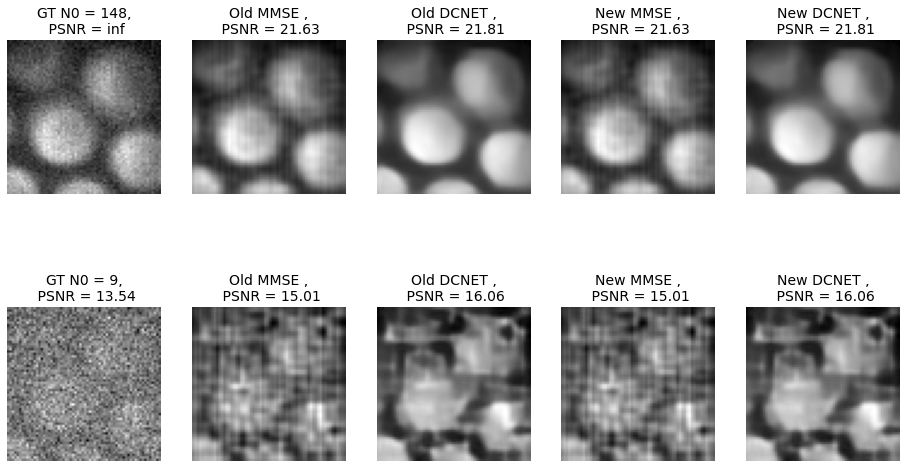

In [14]:
#%% Displaying the results
#Once all the networks have been loaded, we evaluate them on the measurements.
from time import perf_counter
title_lists = [];
Additional_info = [["N0 = {}".format(round(max_list[i])) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];

x_0 = torch.ones((1, img_size**2)).to(device)
with torch.no_grad():
    for i in range(len(GT)):
        
        list_outs = [];
        m_list[i] = m_list[i]*eta;
        
        x_mmse_old = model_list_denoi[0].forward_reconstruct_mmse_expe(m_list[i], 1, 1, img_size, img_size); 
        x_dcnet_old = model_list_denoi[0].forward_reconstruct_expe(m_list[i],1,1, img_size, img_size);
        
        _, N0_est = model_list_denoi[0].forward_preprocess_expe(m_list[i], 1, 1, img_size, img_size) # to get the same N0 as the network
        model_new.PreP.N0 = N0_est.item();
        x_mmse_new = model_new.reconstruct_mmse(m_list[i].view(1, 1, 2*CR)); 
        x_dcnet_new = model_new.reconstruct(m_list[i].view(1, 1, 2*CR));

        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
        #list_outs.append(x_tv);
        list_outs.append(x_mmse_old);
        list_outs.append(x_dcnet_old);
        
        list_outs.append(x_mmse_new);
        list_outs.append(x_dcnet_new);
        
        output = torch.stack(list_outs, axis = 1);

        psnr = batch_psnr_vid(Ground_truth, output);
        outputs.append(torch2numpy(output));
        title_lists.append(["{} {},\n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2)) for j in range(len(titles))]);

o1 = outputs;
t1 = title_lists;
nb_disp_frames = 5
compare_video_frames(outputs, nb_disp_frames, title_lists);

## STL-10 Cat

tensor([[[1027.7900]]], device='cuda:0')
tensor([[[1027.7900]]], device='cuda:0')
tensor([[[1027.7900]]], device='cuda:0')
tensor([[[24.3652]]], device='cuda:0')
tensor([[[24.3652]]], device='cuda:0')
tensor([[[24.3652]]], device='cuda:0')


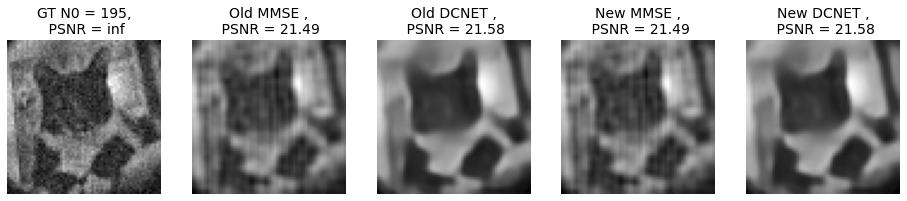

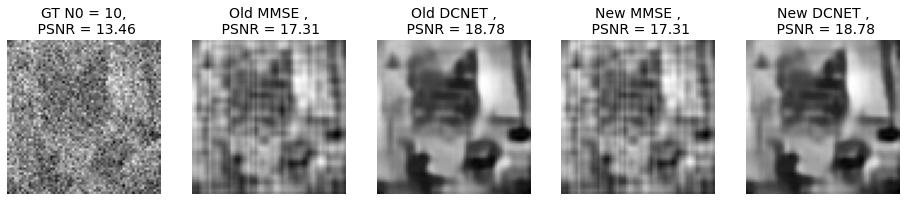

In [15]:
#Loading the Compressed Data
titles_expe = ["stl10_05_1.5_0.0_0{}_variance".format(i) for i in range(1,7)]+\
              ["stl10_05_1_0.3_variance", "stl10_05_1_0.6_variance"]

expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];
nflip = [1.5 for i in range(len(titles_expe))];
nflip[-2:] = [1 for i in range(len(nflip[-2:]))]
channel = 581;
m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);

m_prim = [];

m_prim.append(sum(m_list[:7]));
m_prim.append(m_list[-1]);
m_list = m_prim;

# Loading Ground-Truth
# NB: we normalize it to get the range the neural networks work with.

GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600
GT_prim = [];
GT_prim.append(sum(GT[:7]));
GT_prim.append(GT[-1]);
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];

#%% Methods comparison

# we evaluate the networks on the loaded measurements.
title_lists = [];
Additional_info = [["N0 = {}".format(round(max_list[i])) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];

with torch.no_grad():
    for i in range(len(GT)):
        #
        list_outs = [];
        m_list[i] = m_list[i]*eta;
        
        x_mmse_old = model_list_denoi[0].forward_reconstruct_mmse_expe(m_list[i], 1, 1, img_size, img_size); 
        x_dcnet_old = model_list_denoi[0].forward_reconstruct_expe(m_list[i],1,1, img_size, img_size);
        
        _, N0_est = model_list_denoi[0].forward_preprocess_expe(m_list[i], 1, 1, img_size, img_size) # to get the same N0 as the network
        model_new.PreP.N0 = N0_est.item();
        x_mmse_new = model_new.reconstruct_mmse(m_list[i].view(1, 1, 2*CR)); 
        x_dcnet_new = model_new.reconstruct(m_list[i].view(1, 1, 2*CR));
        
        
        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);

        list_outs.append(x_mmse_old);
        list_outs.append(x_dcnet_old);
        
        list_outs.append(x_mmse_new);
        list_outs.append(x_dcnet_new);
    
        output = torch.stack(list_outs, axis = 1);

        psnr = batch_psnr_vid(Ground_truth, output);
        output = torch2numpy(output);
        output = batch_flipud(output);
        outputs.append(output);
        title_lists.append(["{} {},\n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2)) for j in range(len(titles))]);

o2 = outputs;
t2 = title_lists;
nb_disp_frames = 5;
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);


In [16]:
#%% Compressed Reconstruction via CNN (CR = 3/4)
# Parameters 
num_epochs = 20 ;   # Number of training epochs 
batch_size = 256 ;  # Size of each training batch
reg = 1e-7;         # Regularisation Parameter
lr = 1e-3;          # Learning Rate
step_size = 10;     # Scheduler Step Size
gamma =0.5;         # Scheduler Decrease Rate

CR = 1024;          # Number of patterns

even_index = range(0,2*CR,2);
uneven_index = range(1,2*CR,2);


Pmat = np.dot(Perm,H);
H_k = Pmat[:CR,:];

# Loading Relevant Neural Networks
suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
        img_size, CR, num_epochs, lr, step_size,\
        gamma, batch_size, reg)


N0_list = [2500];

model_list_denoi = net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, 1, H, suffix, model_root);


Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 1250
Denoised Measurements
Model Loaded: ../2021_Optics_express/model/NET_c0mp_N0_2500_sig_0.5_Denoi_N_64_M_1024_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


In [17]:
Hperm = Perm@H*img_size; #for new
Pmat_new = Hperm[:CR,:];

Cov_perm = img_size**2*Perm@Cov_had_1@Perm.T;

N0 = 10 # Juste pour init

FO_split_had = Split_Forward_operator_ft_had(Pmat_new, Perm)
Acq = Bruit_Poisson_approx_Gauss(N0, FO_split_had)
PreP = Split_diag_poisson_preprocess(N0, CR, img_size**2)
DC_layer = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm, M = CR, N = img_size**2)
Denoi = copy.deepcopy(model_list_denoi[0].recon)
model_new = DC_Net(Acq, PreP, DC_layer, Denoi)
model_new.to(device)
model_new.eval()

DC_Net(
  (Acq): Bruit_Poisson_approx_Gauss(
    (FO): Split_Forward_operator_ft_had(
      (Hsub): Linear(in_features=4096, out_features=1024, bias=False)
      (Hsub_adjoint): Linear(in_features=1024, out_features=4096, bias=False)
      (Hpos_neg): Linear(in_features=4096, out_features=2048, bias=False)
      (Perm): Linear(in_features=4096, out_features=4096, bias=False)
    )
  )
  (PreP): Split_diag_poisson_preprocess()
  (DC_layer): Generalized_Orthogonal_Tikhonov(
    (comp): Linear(in_features=1024, out_features=3072, bias=False)
    (denoise_layer): Denoise_layer(in_features=1024)
  )
  (Denoi): Sequential(
    (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu1): ReLU()
    (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

## Siemens Star

In [18]:
titles = ["GT", "Old MMSE","Old DCNET", "New MMSE", "New DCNET"]

# Loading the compressed raw measurements
titles_expe = ["starSectorD_2_0.0_01_variance", "starSectorD_2_0.0_02_variance"]+\
              ["starSectorD_2_0.0_03_variance", "starSectorD_2_0.0_04_variance"]+\
              ["starSectorD_2_0.0_05_variance", "starSectorD_2_0.0_06_variance"]+\
              ["starSectorD_2_0.0_07_variance", "starSectorD_2_0.0_08_variance"]+\
              ["starSectorD_2_0.0_09_variance", "starSectorD_2_0.0_variance"]+\
              ["starSectorD_2_0.3_variance", "starSectorD_2_0.6_variance"]+\
              ["starSectorD_2_1.0_variance", "starSectorD_2_1.3_variance"]

channel = 510;

nflip = [2 for i in range(len(titles_expe))];
expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];

m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);
    
m_prim = [];
m_prim.append(sum(m_list[:10]));
m_prim.append(m_list[10]);
m_list = m_prim;

# Loading Ground Truth
# NB: we normalize it to get the range the neural networks work with.
GT = raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600 -510

GT_prim = [];
GT_prim.append(sum(GT[:10]));
GT_prim.append(GT[10]);
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))]

tensor([[[1574.8867]]], device='cuda:0')
tensor([[[1574.8867]]], device='cuda:0')
tensor([[[1574.8867]]], device='cuda:0')
tensor([[[94.3076]]], device='cuda:0')
tensor([[[94.3076]]], device='cuda:0')
tensor([[[94.3076]]], device='cuda:0')


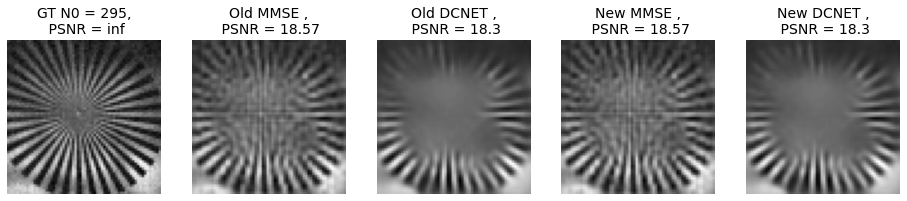

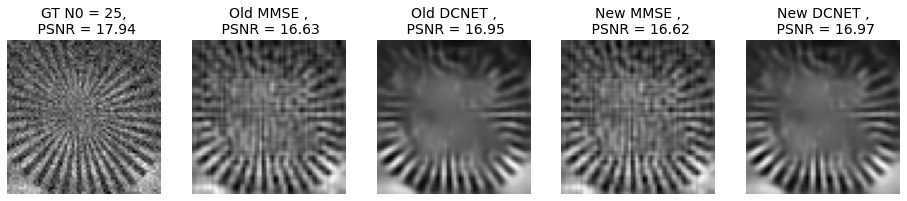

In [19]:
#%% Methods comparison
m_list[0].shape

title_lists = [];
Additional_info = [["N0 = {}".format(round(max_list[i])) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];

with torch.no_grad():
    for i in range(len(GT)):
        
        list_outs = [];
        m_list[i] = m_list[i]*eta
        
        x_mmse_old = model_list_denoi[0].forward_reconstruct_mmse_expe(m_list[i], 1, 1, img_size, img_size); 
        x_dcnet_old = model_list_denoi[0].forward_reconstruct_expe(m_list[i],1,1, img_size, img_size);
        
        _, N0_est = model_list_denoi[0].forward_preprocess_expe(m_list[i], 1, 1, img_size, img_size) # to get the same N0 as the network
        model_new.PreP.N0 = N0_est.item();
        x_mmse_new = model_new.reconstruct_mmse(m_list[i].view(1, 1, 2*CR));
        x_dcnet_new = model_new.reconstruct(m_list[i].view(1, 1, 2*CR));

        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);

        list_outs.append(x_mmse_old);
        list_outs.append(x_dcnet_old);
        
        list_outs.append(x_mmse_new);
        list_outs.append(x_dcnet_new);
    
        output = torch.stack(list_outs, axis = 1);

        psnr = batch_psnr_vid(Ground_truth, output);
        outputs.append(torch2numpy(output));
        title_lists.append(["{} {},\n PSNR = {}".format(titles[j], Additional_info[i][j], round(psnr[j],2)) for j in range(len(titles))]);

o3 = outputs
t3 = title_lists
nb_disp_frames = 5

outputs_0 = outputs[:1]
outputs_1 = outputs[1:4]
title_lists_0 = title_lists[:1]
title_lists_1 = title_lists[1:4]

compare_video_frames(outputs_0, nb_disp_frames, title_lists_0)
compare_video_frames(outputs_1, nb_disp_frames, title_lists_1)

## All objects as in paper

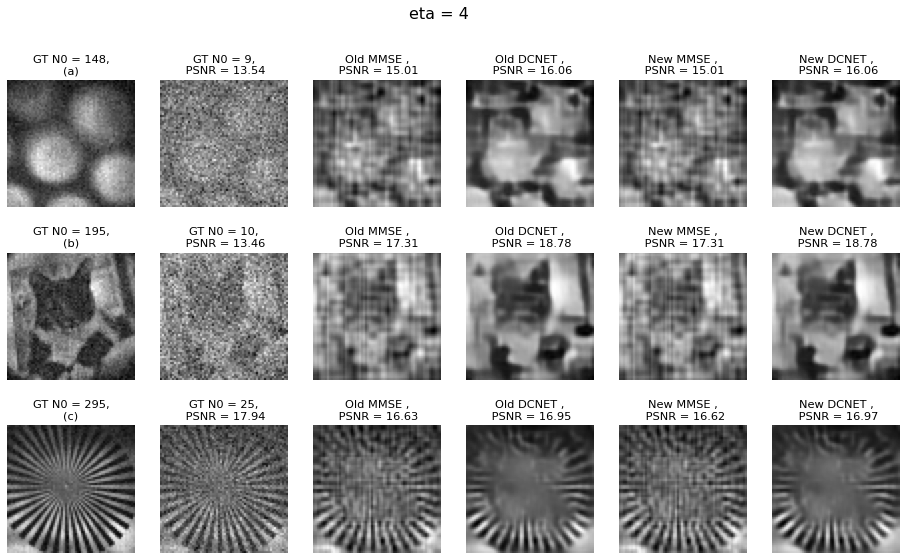

In [20]:
out_lamp = np.concatenate((np.reshape(o1[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o1[-1]), axis = 1)
title_lamp = [t1[0][0][:-11] + "(a)"]+t1[-1]

out_cat = np.concatenate((np.reshape(o2[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o2[-1]), axis = 1)
title_cat = [t2[0][0][:-11] + "(b)"]+t2[-1]

out_star = np.concatenate((np.reshape(o3[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o3[-1]), axis = 1)
title_star = [t3[0][0][:-11] + "(c)"]+t3[-1]

outputs = [out_lamp, out_cat, out_star]
title_lists = [title_lamp, title_cat, title_star]

nb_disp_frames = 6
compare_video_frames(outputs, nb_disp_frames, title_lists, 'eta = {}\n'.format(eta), fontsize = 11.4)